# Data exploration

1. Load the protein data

In [1]:
from biopandas.pdb import PandasPdb
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from rdkit import Chem

In [2]:
opened_protein = PandasPdb().read_pdb("../workshop_data/proteins/cotb2_pp_mg.pdb")

In [3]:
opened_protein.df["ATOM"].head(5)

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,MET,,,1,,...,-18.379,-5.699,-9.533,1.0,0.0,,PEP1,,NaN,2
1,ATOM,2,,HT1,,MET,,,1,,...,-18.233,-5.102,-10.372,1.0,0.0,,PEP1,,NaN,3
2,ATOM,3,,HT2,,MET,,,1,,...,-17.858,-6.592,-9.648,1.0,0.0,,PEP1,,NaN,4
3,ATOM,4,,HT3,,MET,,,1,,...,-18.031,-5.201,-8.689,1.0,0.0,,PEP1,,NaN,5
4,ATOM,5,,CA,,MET,,,1,,...,-19.803,-5.983,-9.378,1.0,0.0,,PEP1,,NaN,6


2. Plot the distribution of amino acids.

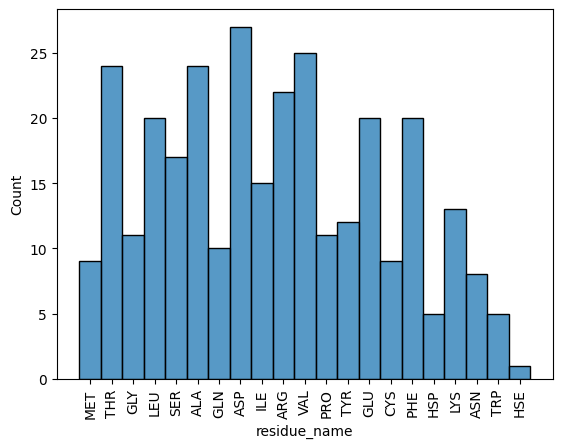

In [4]:
grouped_amino_acids = opened_protein.df["ATOM"].groupby("residue_number").first()
sns.histplot(grouped_amino_acids["residue_name"])
# Rotate the x-axis labels
plt.xticks(rotation=90)
plt.show()


3. Extract the sequence from the protein file and write it into a fasta file

<AxesSubplot:xlabel='residue_name'>

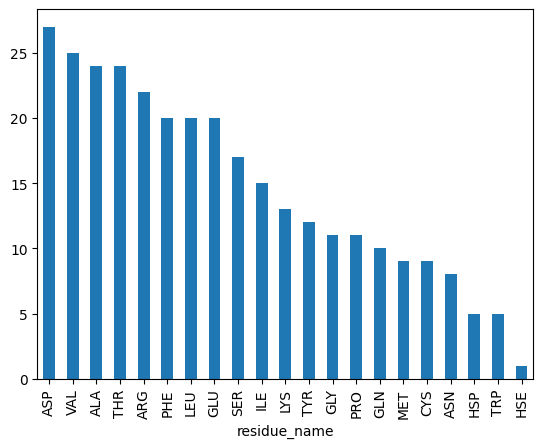

In [5]:
grouped_amino_acids["residue_name"].value_counts().plot(kind="bar")

In [6]:
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y',
    'HSE': 'H', 'HSP': 'H', 'HSD': 'H', 'HIE': 'H', 'HID': 'H',
}

# Convert 3-letter amino acids to sequence
sequence = "".join(grouped_amino_acids["residue_name"].map(aa_dict))
print("Protein sequence:", sequence)
fasta_location = "../workshop_data/proteins/cotb2_pp_mg.fasta"
with open(fasta_location, "w") as f:
    f.write(f">cotb2_pp_mg\n{sequence}")


Protein sequence: MTTGLSTAGAQDIGRSSVRPYLEECTRRFQEMFDRHVVTRPTKVELTDAELREVIDDCNAAVAPLGKTVSDERWISYVGVVLWSQSPRHIKDMEAFKAVCVLNCVTFVWDDMDPALHDFGLFLPQLRKICEKYYGPEDAEVAYEAARAFVTSDHMFRDSPIKAALCTTSPEQYFRFRVTDIGVDFWMKMSYPIYRHPEFTEHAKTSLAARMTTRGLTIVNDFYSYDREVSLGQITNCFRLCDVSDETAFKEFFQARLDDMIEDIECIKAFDQLTQDVFLDLIYGNFVWTTSNKRYKTAVNDVNSRIQA


3. Load the ligands data

In [7]:
original_ligands = pd.read_csv("../workshop_data/ligands/cotb2_energy.txt", header = None, sep = " ")
original_ligands.columns = ["ligand", "energy"]
original_ligands[["lig_generic", "int", "cotb2", "lig_name", "lig_pose"]] = original_ligands["ligand"].str.split("_", expand=True)

loaded_ligands = original_ligands.copy()
loaded_ligands["ligand"] = loaded_ligands["ligand"].str.replace(".pdb", "")
loaded_ligands = loaded_ligands.drop(columns=["lig_generic", "int", "cotb2"])

ligands_to_smiles = loaded_ligands.drop(columns=["ligand", "lig_pose"])
ligands_to_smiles = ligands_to_smiles.groupby("lig_name").median()
ligands_to_smiles = ligands_to_smiles.reset_index()
ligands_to_smiles = pd.merge(ligands_to_smiles, original_ligands[["lig_name", "ligand"]], on = "lig_name", how = "left")

ligands_to_smiles["mol"] = ligands_to_smiles["ligand"].apply(lambda x: Chem.MolFromPDBFile(f"/home/ec2-user/enzyme-ml/workshop_data/ligands_pdbs/{x}", removeHs=False))
ligands_to_smiles["smiles"] = ligands_to_smiles["mol"].apply(lambda x: Chem.MolToSmiles(x))




In [9]:
ligands_to_smiles["smiles"].value_counts()

smiles
[H]C1C(C([H])([H])[H])C([H])([H])C([H])([H])C2([H])C([H])(C(C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C2(C([H])([H])[H])C([H])([H])C([H])C(C([H])([H])[H])C([H])([H])C1([H])[H]    10000
Name: count, dtype: int64

In [10]:
loaded_ligands = loaded_ligands.drop(columns=["ligand"])

4. Plot the Molecular Weight distribution

In [12]:
#sns.histplot(loaded_ligands["Molecular Weight"])
#plt.show()

# Feature extraction

In [11]:
import iFeatureOmegaCLI
protein_features = iFeatureOmegaCLI.iProtein(fasta_location)


In [14]:
help(protein_features)

Help on iProtein in module iFeatureOmegaCLI.iFeatureOmegaCLI object:

class iProtein(Sequence)
 |  iProtein(file)
 |  
 |  # Running examples:
 |  # import iFeatureOmegaCLI
 |  >>> import iFeatureOmegaCLI
 |  
 |  # create a instance
 |  >>> protein = iFeatureOmegaCLI.iProtein("./data_examples/peptide_sequences.txt")
 |  
 |  # display available feature descriptor methods
 |  >>> protein.display_feature_types()
 |  
 |  # import parameters for feature descriptors (optimal)
 |  >>> protein.import_parameters('parameters/Protein_parameters_setting.json')
 |  
 |  # calculate feature descriptors. Take "AAC" as an example.
 |  >>> protein.get_descriptor("AAC")
 |  
 |  # display the feature descriptors
 |  >>> print(protein.encodings)
 |  
 |  # save feature descriptors
 |  >>> protein.to_csv("AAC.csv", "index=False", header=False)
 |  
 |  Method resolution order:
 |      iProtein
 |      Sequence
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  CalculateContent(self, myDist

In [15]:
protein_features.display_feature_types()


        ----- Available feature types ------        
        
        AAC                                                Amino acid composition
        EAAC                                               Enhanced amino acid composition
        CKSAAP type 1                                      Composition of k-spaced amino acid pairs type 1 - normalized
        CKSAAP type 2                                      Composition of k-spaced amino acid pairs type 2 - raw count
        DPC type 1                                         Dipeptide composition type 1 - normalized
        DPC type 2                                         Dipeptide composition type 2 - raw count
        TPC type 1                                         Tripeptide composition type 1 - normalized
        TPC type 2                                         Tripeptide composition type 1 - raw count
        CTDC                                               Composition
        CTDT                                      

In [16]:
descriptor_blocks = ["AAC", "DistancePair", "BLOSUM62"]
features = []
protein_features = iFeatureOmegaCLI.iProtein(fasta_location)
for current_descriptor_block in descriptor_blocks:
    protein_features.get_descriptor(current_descriptor_block)
    features.append(protein_features.encodings.reset_index(drop=True)) 

In [17]:
features_df = pd.concat(features, axis=1)

In [20]:
loaded_ligands

,energy,lig_name,lig_pose
0,-21.457340,100,100.pdb
1,-44.423028,100,10.pdb
2,-29.692781,100,11.pdb
3,-0.501767,100,12.pdb
4,-28.634483,100,13.pdb
...,...,...,...
9995,-44.522233,99,98.pdb
9996,1.342737,99,99.pdb
9997,-44.696832,9,99.pdb
9998,-44.200910,99,9.pdb


## Small molecules

In [18]:
from collections import Counter
possible_atoms = ["C", "N", "O", "S", "P"]
for current_atom in possible_atoms:
    loaded_ligands[current_atom + "_number"] = loaded_ligands["Smiles"].apply(lambda x: Counter(x)[current_atom])


KeyError: 'Smiles'

In [14]:
from mordred import Calculator, descriptors
from rdkit import Chem

calc = Calculator(descriptors, ignore_3D=True)
rdkit_mol_list = [Chem.MolFromSmiles(smiles) for smiles in loaded_ligands["Smiles"][0:3]]
mols = calc.pandas(rdkit_mol_list)
mols.head(5)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,68.884685,2.538539,4.998878,68.884685,1.275642,4.908538,...,11.052111,107.262972,778.289544,7.483553,12305,103,286.0,348.0,21.555556,12.166667
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,1,1,85.701835,2.546244,5.022834,85.701835,1.298513,5.128588,...,11.326560,122.567525,932.342642,7.642153,19879,129,364.0,448.0,23.722222,14.472222
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,44.777180,2.418860,4.821130,44.777180,1.243811,4.489361,...,10.367127,86.506882,506.178812,7.669376,4920,55,182.0,210.0,13.944444,7.944444
